# Persisting Data

The WoT proxy acts as an **intermediary** that exposes physical devices (such as sensors and actuators) through standardized web interfaces. These interfaces typically follow RESTful principles or lightweight protocols like CoAP, enabling seamless access and interoperability. While much of the focus in WoT systems is on **real-time interaction**s and **device integration**, a critical requirement in real-world deployments is the ability to **persist data**. Persistence refers to the system’s ability to **store data beyond the lifetime of a single session or execution**, thus ensuring that information can be **recovered**, **analyzed**, or **acted** upon at a later time. This includes, for example, logging temperature readings over time, tracking the history of actuator commands, or maintaining configuration metadata.

The current WoT proxy implementation uses a hierarchical object to represent its internal data model. This **in-memory structure** reflects the current state of the system, including sensor values and actuator statuses. However, because the model resides entirely in memory, it is **inherently volatile**. When the proxy is restarted, all data is lost unless explicit mechanisms are introduced to persist this information in a durable manner.

Understanding how to implement persistence in a Node.js application is therefore essential. Persistence can be approached in multiple ways, ranging from **simple file-based storage** to the use of more **sophisticated and scalable database systems**.

Node.js, thanks to its large ecosystem and community, supports a wide range of database systems. Among the most popular choices are **PostgreSQL**, **MySQL**, **Redis**, **SQLite**, and **MongoDB**. Each database offers distinct advantages, and the decision to use one over another depends on various factors. These include the time required to become productive with the tool, the learning curve involved, the performance characteristics of the database engine, ease of replication and backup, as well as the cost of deployment and the level of support offered by the user community.

Importantly, **there is no universally “best” database**. Each use case may benefit from a different approach. For example, applications requiring complex relational queries may prefer SQL-based systems like PostgreSQL, while those dealing with flexible, document-oriented data structures might opt for MongoDB. What matters most is selecting a solution aligned with the technical constraints and development needs of the project.

## MongoDB

[**MongoDB**](https://www.mongodb.com/try/download/community) stores data in a flexible, JSON-like format called **BSON** (Binary JSON) and allows for easy representation of complex data types and relationships, making it particularly well-suited for applications that require rapid development and fast changing data requirements. 

It is a alternative to **traditional relational database** systems and is part of a family of **NoSQL databases** that have emerged to address the limitations of older, schema-bound, table-based models. While relational databases remain powerful and widely used, their underlying architecture were originally designed with strong assumptions about **fixed schemas**, **centralized deployment**, and **vertically scaled infrastructures**. These assumptions do not always align well with the demands of contemporary applications, particularly in the context of large-scale distributed systems or r**apidly evolving data models**. For instance, schema evolution in SQL databases typically requires altering table definitions and migrating data, which can be costly and error-prone in production environments.

MongoDB addresses several of these limitations through its **schema-flexible model**. MongoDB can store documents with **heterogeneous structures**, allowing developers to **adapt data formats over time** without the need for rigid schema declarations. This approach is especially useful in applications where data requirements are dynamic or partially unstructured, such as sensor readings, user-generated content, or log data. Additionally, because MongoDB documents are structurally compatible with JSON, they integrate seamlessly with JavaScript-based environments, including Node.js. This reduces the impedance mismatch between application code and persistent storage.

Moreover, **SQL joins** (while expressive and mathematically elegant) can be **difficult to manage** in systems where performance, latency, and simplicity are key concerns. Although relational joins are powerful, they often introduce a cognitive overhead for developers and can lead to performance issues when used extensively across large datasets. While modern relational systems have improved in scalability and flexibility, many were originally optimized for the hardware and workloads of previous decades.

That said, MongoDB also introduces some trade-offs. The absence of enforced schemas means that data consistency must often be handled at the application level. Querying capabilities, while substantial, may **lack some of the expressiveness** and optimization opportunities of advanced SQL engines. Complex joins, for instance, are not natively supported in the same way as in relational databases and must be implemented via **embedding** (nesting documents within documents) or **linking** (storing references and resolving them in application logic or using aggregation pipelines).

### Collection, document, and field

In MongoDB, we define **collection** a group of documents that share a similar purpose or structure. For example, we might have a collection for users, another for products, and another for orders. Each **document** in a collection is a JSON-like object contains a list of fiels. Each **field** is a key-value pair, where the key is a string and the value can be a variety of data types, including strings, numbers, arrays, or even nested documents.

To understand **how MongoDB stores data**, it helps to first compare it with relational databases, which are often the default in traditional applications. Even if you’ve never worked with a database before, you’re probably familiar with the idea of a spreadsheet: you have a table made of rows and columns. In a relational database, data is organized very similarly to a spreadsheet. You define a table, where each row represents an individual record (like one user, one product, or one sensor reading), and each column defines a specific type of information (such as name, date, or temperature). In a relational databases, the structure of data is **strictly defined at the table level**. When creating a table, developers must define in advance the names and types of all columns, and every row stored in the table must comply with this predefined schema. 

MongoDB, by contrast, takes a **document-oriented approach**. Instead of enforcing a common schema for all records in a collection, MongoDB allows each document to define its own fields independently. This means that documents within the same collection can have different structures and may contain different sets of keys. The database does not impose any global constraint on the shape of the data. This behavior is commonly described as **schema-less** or **schema-flexible**.

To better understand how MongoDB structures data, it is useful to draw parallels with relational databases by mapping its core components to more familiar concepts:

- A **collection** is like a table in a relational database, it groups similar pieces of data together.
- A **document** is like a row in a table, it represents one item, like a user or a temperature reading.
- A **field** is like a column—it holds a single piece of information, like a name or a value.

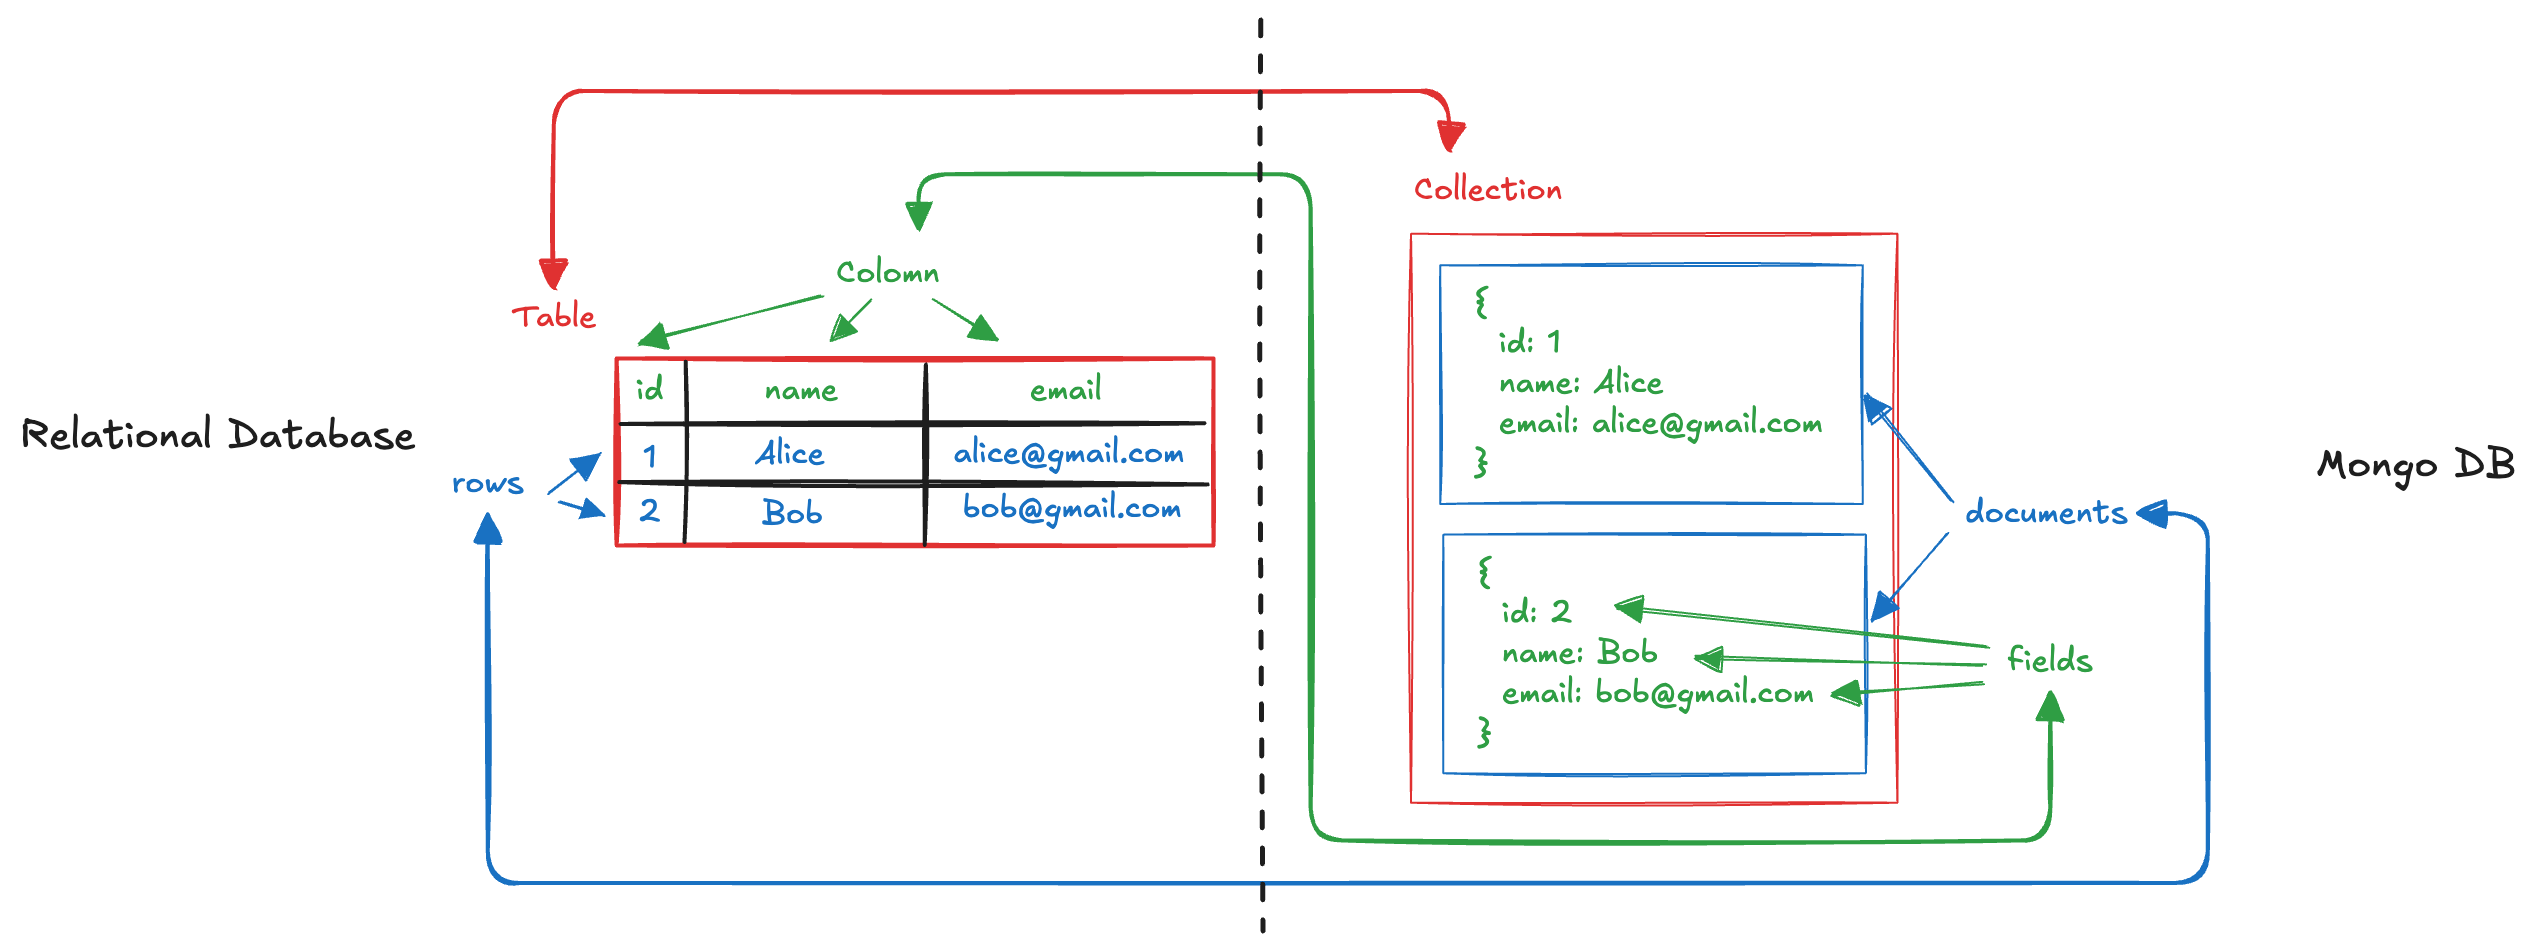

This schema flexibility allows MongoDB to store data that **evolves over time or varies between devices or users**. For example, in a sensor network, one device may record only temperature, while another may include humidity and air pressure. In MongoDB, these can be stored side-by-side in the same collection without the need to update a schema or perform table migrations.

To work with MongoDB, the first step is installing the server and a shell interface. The official MongoDB documentation provides installation instructions across various platforms. Then we can run it manually:

In [ ]:
mongod --config /opt/homebrew/etc/mongod.conf

We need a graphical client to visualize the data. The official **MongoDB Compass client** is a good choice, but there are many other options available. A very popular graphical client, [**Studio 3T**](https://studio3t.com/free/), is also available and can simplify exploration and querying. Interaction can take place through its built-in shell, which uses a JavaScript-like syntax. Basic commands include: 

In [ ]:
// Display available methods
db.help() 

// Show statistics about the current database
db.stats()

// List all existing collections
db.getCollectionNames() 

In MongoDB, we don’t explicitly create a database with a separate command (like in SQL). Instead, a database is **created implicitly the first time we store data in it**.

In [ ]:
use myNewDatabase

At this point, myNewDatabase is selected as our current database, but it doesn’t actually exist yet. Also **collections are created implicitly**. There is no need to define them in advance. When we insert a document into a collection that does not yet exist, MongoDB automatically creates it. For example, inserting a sensor reading can be done as simply as:

In [ ]:
db.sensors.insertOne({ 
    type: "temperature", 
    unit: "celsius", 
    value: 22 
})

Once we do this, MongoDB will create: the database myNewDatabase, the collection sensors and the first document inside it. Because MongoDB collections are schema-less, we can insert documents with different structures into the same collection. For example, after inserting a temperature reading, we could insert a heart rate reading with a completely different set of fields:

In [ ]:
db.sensors.insert({
  name: 'HeartRate',
  device: 'Pulsimeter'
})

MongoDB accepts this without complaint, and **both documents will now coexist in the sensors collection**, despite having different fields. This **dynamic behavior** and **flexibility** supports rapid prototyping and development, but it also requires discipline at the application level and it is recommended to **enforce structure at the application level**, for instance using libraries like Mongoose.

### Arrays and Embedded Documents

Unlike traditional relational databases where **each column has a single scalar** type (e.g., INTEGER, VARCHAR), MongoDB fields can store not only simple values, but also **complex structures** like **arrays** and **embedded documents** as native data types within documents. This allows for the direct modeling of complex, hierarchical, or relational data structures in a way that is both **intuitive** and **efficient**, without the need for traditional relational joins or link tables.

In relational databases, **many-to-many** or **many-to-one** relationships are typically represented using **join tables**. In MongoDB, the same kinds of relationships can be modeled more directly by storing arrays of values or references inside documents. For example, consider a situation where a measurement is recorded by multiple devices. Instead of representing this using a join table, we can store an array of ObjectIds referencing the devices:

In [ ]:
db.measurements.insert({
  _id: ObjectId('4d85c7039ab0fd70a117d733'),
  value: 76,
  devices: [
    ObjectId('6272386cdf012d4f4ba31b3b'),
    ObjectId('6272386cdf012d4f4ba31b3c')
  ]
})

Here, the devices field is **an array of references** to device documents. In addition to arrays, MongoDB supports **embedded documents**, which are nested within other documents. This is particularly useful when related data is always accessed together:

In [ ]:
db.measurements.insert({
  value: 96,
  user: {
    name: 'Pio',
    surname: 'Blu'
  }
})

Here, the user field is a **sub-document** that contains its own fields. It is especially useful in cases where the nested information is **not reused elsewhere** and is always accessed together. This flexibility enables the modeling of hierarchical or nested data directly within a single document, without the need for foreign keys or joins.

We can **combine** both concepts to create **arrays of embedded documents**. This is useful in scenarios such as storing a list of sensor readings, comments, locations, or historical states directly within a parent document:

In [ ]:
db.devices.insert({
  device: 'thermometer-1',
  readings: [
    { timestamp: '2024-01-01T12:00:00Z', value: 22.1 },
    { timestamp: '2024-01-01T12:05:00Z', value: 22.3 }
  ]
})

This structure improves read performance and simplifies data modeling when the embedded elements are tightly related to the parent and are not queried independently.

### Find documents

Once data is stored in a collection, the most basic and frequently used operation is **reading it back**. This is done using the find() method. In its simplest form, calling find() with no parameters returns all documents in the current collection. For example, we have previously inserted a temperature reading into a collection called sensors, we can retrieve it with:

In [ ]:
db.sensors.find()

We obtain a JSON list with the data we just inserted:

In [ ]:
[
    {
        "_id" : ObjectId("682c46eef6228fe221ea7e0f"),
        "type" : "temperature",
        "unit" : "celsius",
        "value" : NumberInt(22)
    },
    {
        "_id" : ObjectId("682c7925ccb76ce603ea7e0f"),
        "name" : "HeartRate",
        "device" : "Pulsimeter"
    }
]

### ObjectId

The result of the finde operation contains not only the fields we inserted (name, unit, value), but also **a special field named _id**. This field is automatically added by MongoDB if not explicitly provided. Its purpose is to serve as the **primary key for the document**, uniquely identifying it within the collection. Every document must have a unique _id. MongoDB will raise an error if two documents share the same value for this field.

By default, the value of _id is of type **ObjectId**, a special 12-byte identifier generated by MongoDB that encodes a timestamp and some random bits. While we can manually assign a value to _id, it is generally best to let MongoDB manage it unless we have a specific reason to control it.

### Indexes

An important aspect of _id is that it is **automatically indexed**. This means that searching for documents by _id is very **efficient**. We can verify the presence of this index using:

In [ ]:
db.sensors.getIndexes()

This command lists all indexes associated with the collection, and we will see an entry for the _id field:

In [ ]:
[
    {
        "v" : 2.0,
        "key" : {
            "_id" : 1.0
        },
        "name" : "_id_"
    }
]

Indexes function much like indexes in traditional relational databases. They are critical for **enhancing query performance**, particularly for large collections, by allowing MongoDB **to locate documents without scanning every entry in the collection**. When we query a collection without an index, MongoDB performs a **collection scan**, it examines every document to check whether it matches the query criteria. This is inefficient for large datasets. An index creates **a special data structure**, typically a **B-tree**, a balanced tree data structure that stores the indexed field values in **sorted order**, allowing efficient retrieval. Indexes are created using the createIndex() method and removed using dropIndex(). For example:

In [ ]:
db.devices.createIndex({ name: 1 })

This creates an ascending index on the name field. To remove the same index:

In [ ]:
db.devices.dropIndex({ name: 1 })

The value 1 indicates ascending order; using -1 would create a descending index instead. We can enforce **uniqueness** on a field by specifying the unique option. This ensures that MongoDB will reject any insert or update that would cause duplicate values in the indexed field:

In [ ]:
db.devices.createIndex({ name: 1 }, { unique: true })

MongoDB allows the creation of **compound indexes**, which index **multiple fields in a single structur**e. These are helpful for queries that involve filtering or sorting on more than one field.

In [ ]:
db.devices.createIndex({ name: 1, values: -1 })

MongoDB supports **indexing nested fields** (using dot notation) and fields that contain arrays:

In [ ]:
db.devices.createIndex({ 'user.name': 1 })

This creates an index on the name field of an embedded user object. If a field contains an array, MongoDB automatically creates **a separate index entry for each element of the array**. This allows us to efficiently query documents where any array element matches a condition. MongoDB offers **specialized index types** for specific use cases, including:

- **Geospatial Indexes** for querying location data (2dsphere)
- **Text Indexes** for full-text search on strings
- **Hashed Indexes** for sharding on a hashed key

These advanced indexes are beyond the scope of this chapter but are covered in detail in the MongoDB documentation.

### Query Selectors

It is often necessary to retrieve **only a subset of documents** from a collection based on certain **conditions**. This is done using **query selectors**, which serve a similar role to the **WHERE clause** in SQL. These selectors are passed as arguments to the find() function (and other operations such as count(), update(), and delete()), and are expressed as JavaScript objects that define **criteria a document must meet** in order to be included in the result set. MongoDB evaluates each document against the query conditions and returns only the ones that match. To experiment with query selectors, we can begin by loading some sample documents into a collection, which include multiple devices with various attributes like type, weight, tags, and values:

In [ ]:
db.devices.insert({
        name: 'Device 1', 
        timestamp: new Date(1992,2,13,7,47), 
        tags: ['tag_a','tag_b'], 
        weight: 600,
        type: 'm',
        values: 63
    }); 

db.devices.insert({   
        name: 'Device 2',
        timestamp: new Date(1991, 0, 24, 13, 0), 
        tags: ['tag_a', 'tag_c'], 
        weight: 450,
        type: 'f',
        values: 43
    }); 

db.devices.insert({
        name: 'Device 3',
        timestamp: new Date(1973, 1, 9, 22, 10), 
        tags: ['tag_d', 'tag_e'], 
        weight: 984,
        type: 'm',
        values: 182
    }); 

db.devices.insert({
        name: 'Device 4',
        timestamp: new Date(1979, 7, 18, 18, 44), 
        tags: ['tag_f'],
        weight: 575,
        type: 'm',
        values: 99
    }); 

db.devices.insert({
        name: 'Device 5',
        timestamp: new Date(1985, 6, 4, 2, 1), 
        tags:['tag_f', 'tag_a', 'tag_g'], 
        weight:550,
        type:'f',
        values:80
    }); 
    
db.devices.insert({
        name:'Device 6', 
        timestamp: new Date(1998, 2, 7, 8, 30), 
        tags: ['tag_h', 'tag_i'], 
        weight: 733,
        type: 'f',
        values: 40
    }); 
    
db.devices.insert({
        name:'Device 7',
        timestamp: new Date(1997, 6, 1, 10, 42), 
        tags: ['tag_c', 'tag_i'],
        weight: 690,
        type: 'm',
        values: 39
    }); 
        
db.devices.insert({
        name: 'Device 8',
        timestamp: new Date(2005, 4, 3, 0, 57), 
        tags: ['tag_f', 'tag_l'], 
        weight: 421,
        type: 'm',
        values: 2
    }); 

db.devices.insert({
        name: 'Device 9',
        timestamp: new Date(2001, 9, 8, 14, 53), 
        tags: ['tag_f', 'tag_m'], 
        weight: 601,
        type: 'f',
        values: 33
    }); 
    
db.devices.insert({
        name: 'Device 1',
        timestamp: new Date(1997, 2, 1, 5, 3), 
        tags: ['tag_f', 'tag_m'], 
        weight: 650,
        type: 'm',
        values: 54
}); 

db.devices.insert({
        name: 'Device 1',
        timestamp: new Date(1999, 11, 20, 16, 15), 
        tags: ['tag_c', 'tag_a'],
        weight: 540,
        type: 'f'
    });

db.devices.insert({
        name: 'Device 1',
        timestamp: new Date(1976, 6, 18, 18, 18), 
        tags: ['tag_c', 'tag_m'], weight: 704,
        type: 'm',
        values: 165
    });

The most basic query checks for **equality between a field and a value**. For example:

In [ ]:
db.devices.find({ type: 'm' })

This will return all documents where the type field is exactly equal to 'm'. We can specify **multiple field-value pairs** in the query object. This creates an **implicit AND condition**, meaning all conditions must be met simultaneously:

In [ ]:
db.devices.find({ type: 'm', weight: 650 })

This retrieves documents where type is 'm' and weight is 700. MongoDB allows us to **query embedded fields** using dot notation:

In [ ]:
db.measurements.find({ 'user.name': 'Pio' })

MongoDB provides a set of **special operators** for more complex comparisons. These include:

- **$lt**: less than
- **$lte**: less than or equal
- **$gt**: greater than
- **$gte**: greater than or equal
- **$ne**: not equal

As an example, to find all devices of type "m" whose weight is greater than 700:

In [ ]:
db.devices.find({ type: 'm', weight: { $gt: 700 } })

Or to find all devices where type is not "f" and weight is less than or equal to 700:

In [ ]:
db.devices.find({ type: { $ne: 'f' }, weight: { $lte: 700 } })

We can also query for the **presence or absence of a field** using the *$exists* operator:

In [ ]:
db.devices.find({ values: { $exists: false } })

This returns all documents where the values field is missing. If we want to **match any value from a list**, use the **$in** operator. It acts like **a logical OR within a field**:

In [ ]:
db.devices.find({ tags: { $in: ['tag_a', 'tag_c'] } })

This retrieves documents where the tags array contains either 'tag_a' or 'tag_c'. MongoDB also allows **combining multiple conditions using $or**, which is explicitly defined as an array of sub-conditions:

In [ ]:
db.devices.find({
  type: 'f',
  $or: [
    { tags: 'tag_c' },
    { weight: { $lt: 600 } }
  ]
})

This query returns all documents where the type is 'f', and either the tags field contains 'tag_c' or the weight is less than 600. By mastering these query selectors, developers gain precise control over which documents are retrieved from a collection, enabling both **simple filters** and **more advanced search logic**.

The same query selectors used in find() can also be applied to other operations: 

In [ ]:
// Remove all documents where tags includes 'obsolete'
db.devices.remove({ tags: 'obsolete' })

// Count how many documents contain a particular field
db.devices.count({ type: 'sensor' })

This consistency allows developers to use a unified syntax across different types of operations.

### Projection

When retrieving documents, we may not always need all the fields. MongoDB allows us to **specify which fields to include or exclude in the result** set using **projection**. This is done by passing a second argument, which is an object that specifies the desired fields. For example, if we want to retrieve only the name field from our documents:

In [ ]:
db.devices.find({}, { name: 1 })

By default, MongoDB always includes the _id field. If we wish to exclude it, we must do so explicitly:

In [ ]:
db.devices.find({}, { name: 1, _id: 0 })

It is important to note that a projection in MongoDB must be **either inclusive or exclusive**, meaning we can choose to specify only the fields to include (e.g., { name: 1, weight: 1 }) or only the fields to exclude (e.g., { name: 0, unit: 0 }), but we **cannot mix inclusion and exclusion** in the same projection **with the exception of the _id field**. The _id field can be excluded (using _id: 0) in an otherwise inclusive projection.

### Lazy Evaluation

When we perform a query in MongoDB using find(), the database does **not immediately return the entire result set**. Instead, it returns a **cursor**, a pointer to the result set that f**etches documents lazily**, i.e., only as they are needed. This design provides both **memory efficiency** and **performance benefits**, especially when dealing with large datasets.

Lazy evaluation means that MongoDB does not load all matching documents into memory immediately after you issue a query. Instead, **documents are retrieved from the server in batches** as the application or shell begins to iterate over the results. This helps avoid wasting resources on documents that may never be used.

In practice, this behavior is **often hidden in the shell**, because the shell automatically iterates over the cursor to display a sample of the results. For example, when we type:

In [ ]:
db.devices.find()

the shell appears to instantly return all results. In reality, it is fetching documents on-demand and only a subset at first. In the shell, we can simulate explicit cursor iteration:

In [ ]:

const cursor = db.devices.find();

while (cursor.hasNext()) {
    printjson(cursor.next());
}

This loop retrieves documents one at a time, allowing us to observe the **lazy evaluation as documents are fetched incrementally** from the server. MongoDB by default retrieves documents in batches (typically 101 documents for the first batch and 4.096 for subsequent ones). We can control this behavior using the .batchSize(n) method:

In [ ]:

db.devices.find().batchSize(10)


This can be useful in applications where precise control over network traffic and memory usage is required.

### Ordering and Pagination

To order query results, MongoDB provides the sort() method, which takes a document specifying the fields to sort by and the direction (1 for ascending order, and -1 for descending order):

In [ ]:
db.devices.find().sort({ weight: -1 })

For example, this sort results by descending weight. To sort by name (ascending) and values (descending):

In [ ]:
db.devices.find().sort({ name: 1, values: -1 })

For applications that display results in **pages** (e.g., web interfaces or dashboards), MongoDB supports pagination via the limit() and skip() cursor methods:

db.devices.find().sort({ weight: -1 }).limit(2).skip(1)

This example retrieves the second and third heaviest devices by first sorting the documents in descending order by weight, then skipping the first one and limiting the output to the next two. Pagination is an essential feature for scalable user interfaces and APIs, especially when working with large collections. It is always recommended to use pagination in production applications rather than returning entire datasets.

Lazy evaluation is particularly important in ordering and pagination, as it ensures that MongoDB retrieves and processes only the subset of documents needed for the current page, rather than loading the entire sorted dataset into memory—making queries more efficient and scalable, especially on large collections.

### Update documents

Updating documents is a fundamental operation that allows us to **modify existing data within a collection**. The basic idea is to locate the documents to modify and then apply specific changes to them. While the syntax appears simple, understanding how it works in different scenarios is essential to avoid unintended behavior. Mongo requires the use of **atomic update operators**, such as **$set**, **$inc**, and **$unset**. These operators **explicitly define which parts of a document should be changed**. For example, to updateOne() method is used to update a single document:

In [ ]:
db.devices.updateOne(
  { name: 'Device 2' },
  { $set: { weight: 590 } }
)

This command finds the first document where name is "Device 2" and updates only the weight field, leaving all other fields unchanged. The **$set operator** is used to specify the field to be updated and its new value. If the field does not exist, it will be created. The **$inc operator** increments or decrements numeric fields:

In [ ]:
db.devices.updateOne(
  { name: 'Device 3' },
  { $inc: { values: -2 } }
)

The **$unset operator** removes a field from the document:

In [ ]:
db.devices.updateOne(
  { name: 'Device 3' },
  { $unset: { obsoleteField: "" } }
)

To **update all documents** that match a query, use updateMany() instead of updateOne():

In [ ]:
db.devices.updateMany(
  { type: 'f' },
  { $set: { obsoleteField: "obsolete" } }
)

MongoDB also supports **upserts**, which update the matching document if found, or insert a new one if not:

In [ ]:
db.devices.updateOne(
  { name: 'Device 15' },
  { $set: { hits: 1 } },
  { upsert: true }
)

If "Device 15" exists, its hits field is updated. If not, a new document is inserted with name and hits.

### Aggregation

Aggregation is **the process of analyzing and transforming data** to produce computed results, often by **summarizing**, **filtering**, or **reshaping** multiple documents. It is like SQL’s **GROUP BY**, or **COUNT()** clauses. Aggregation is especially useful when we want t**o group values from multiple documents**, calculate **statistical metrics** (like sums or averages), or **prepare data** for reports and dashboards. 

The **aggregation pipeline** is the most powerful and flexible approach. It uses a series of **transformation stages**, each operating on the output of the previous one, to progressively reshape and analyze the data:

In [ ]:
db.devices.aggregate([
  // stages go here
])

Each stage is defined as a JSON object and uses operators like **$match**, **$group**, **$project**, **$sort**, and others. The first stage is often $match, which filters documents based on a condition (similar to find()):

In [ ]:
{ $match: { weight: { $gt: 700 } } }

The next stage could be $group, which allows us to group documents by a specific field and apply aggregation functions such as $sum, $avg, $max, or $min:

In [ ]:
{
  $group: {
    _id: null,
    total: { $sum: "$values" }
  }
}

Putting these together:

In [ ]:
db.devices.aggregate([
  { $match: { weight: { $gt: 700 } } },
  { $group: { _id: null, total: { $sum: "$values" } } }
])

This example filters devices with weight > 700 and computes the total of their values field. Aggregation pipelines are **extremely versatile** and support dozens of stages for tasks like projection, array unwinding, joining collections ($lookup), and reshaping documents ($project, $addFields, etc.).

MongoDB also provides some **built-in helper methods** for **common aggregation** tasks:
- estimatedDocumentCount() gives an approximate count of all documents in a collection.
- countDocuments() returns an exact count, optionally with a filter.
- distinct(field) returns all the unique values for a specified field.

These methods are simpler and faster for basic aggregation but lack the composability of pipelines.

### Replication and Sharding

To support **large-scale**, **reliable**, and **fault-tolerant** applications, MongoDB provides built-in mechanisms for replication and sharding.

A **replica set** is a group of MongoDB servers that maintain the same dataset:

- a replica set typically includes one primary and two or more secondary nodes.
- all writes and strongly consistent reads are handled by the primary node.
- The secondary nodes receive data updates asynchronously via replication and can serve read-only queries.

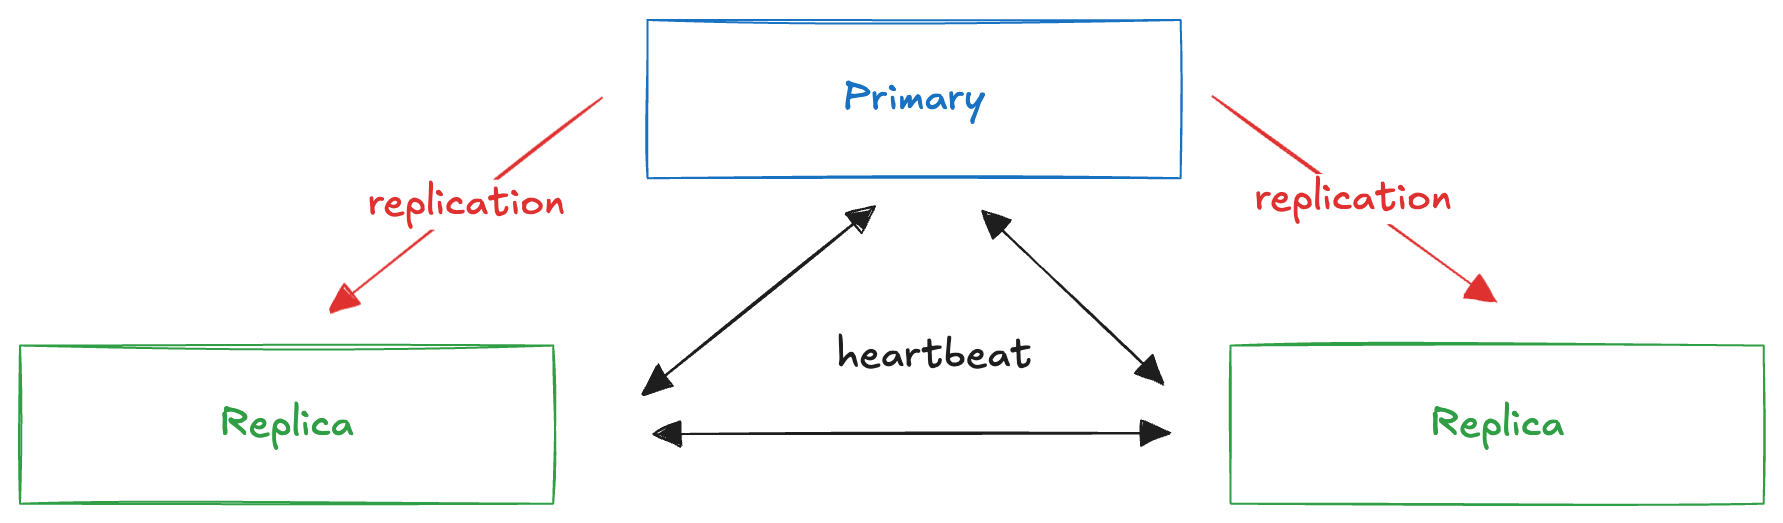

Key Benefits are  **high availability** (if the primary fails, the system automatically promotes a secondary to become the new primary via an election process), **performance optimization** (long-running or read-intensive queries can be offloaded to secondaries, freeing the primary for write operations) and **durability** (data is maintained across multiple nodes, reducing the risk of data loss). However, reading from secondaries introduces a potential for **slightly stale data**, depending on replication lag.

**Sharding** is a method for **horizontal scaling**. It works by partitioning data across multiple machines (called shards), each holding only a subset of the total data. This allows to handle datasets that exceed the capacity of a single machine, both in terms of storage and query throughput:

- Data is divided based on a **shard key**, such as a user ID or geographic region.
- A **router** (mongos) directs queries to the appropriate shard.
- A config server stores metadata about the **distribution of data** across shards.

The **CAP theorem** (**Consistency**, **Availability**, **Partition tolerance**) states that in a distributed system, we can only **guarantee two out of the three properties** at any given time:

- **Consistency**: every read receives the most recent write or an error.
- **Availability**: every request receives a (non-error) response, even if it’s not the most recent.
- **Partition Tolerance**: the system continues to operate even if some nodes cannot communicate due to a network partition.

In practice, partition tolerance is unavoidable, so systems must choose between **consistency** and **availability**

### Transactions

A transaction is a sequence of one or more operations that are **executed as a single, atomic unit of work**. This means that either all operations in the transaction are successfully applied, or none are, ensuring the database remains in a consistent state even in the event of errors or interruptions. The **ACID** properties (Atomicity, Consistency, Isolation, Durability) allows applications to safely modify multiple elements:

- **Atomicity**: a transaction is treated as a single unit. Either all the operations within the transaction succeed together, or none are applied at all.
- **Consistency**: the database is always transitioned from one valid state to another. A transaction cannot leave the database in an invalid state.
- **Isolation**: concurrent transactions are executed as if they were run sequentially. Intermediate results are invisible to other operations.
- **Durability**: once a transaction is committed, its effects persist, even in the event of a crash or power failure.

MongoDB supports **atomic updates on individual document**s. This means that if we modify a single document (including any of its embedded fields or arrays) the entire operation is guaranteed to be atomic. Since MongoDB supports rich document structures, many relationships (e.g., a blog post and its comments) can be embedded within a single document. This often **eliminates the need for multi-document transactions** in many real-world applications.

However, sometimes related data must be updated across multiple documents, collections, or even databases. MongoDB supports **full ACID transactions across multiple documents, collections, and even databases**, starting from version 4.0 (for replica sets) and 4.2 (for sharded clusters). Single-document operations remain atomic by default, making MongoDB suitable for many use cases without the overhead of full transactions:

In [ ]:
const session = db.getMongo().startSession();

session.startTransaction();

try {
  session.getDatabase('store').orders.insertOne({ item: 'Book', qty: 1 });
  session.getDatabase('store').inventory.updateOne(
    { item: 'Book' },
    { $inc: { stock: -1 } }
  );
  session.commitTransaction();
} 

catch (e) {
  session.abortTransaction();
  throw e;
} 

finally {
  session.endSession();
}

This transaction inserts a new order and decrements inventory, ensuring that both changes either succeed together or not at all. Use transactions when changes across multiple documents must be applied together, and always prefer simpler atomic operations when they suffice.

### Profile and Backup

To maintain, monitor, and safeguard MongoDB databases, developers have access to several built-in tools and commands. These enable us to inspect the database’s internal state, monitor performance, and manage backups and data exports.

MongoDB provides internal commands to obtain **basic statistics** about a database or collection.

In [ ]:
// Get information about the current database
db.stats() 

// Retrieve collection-specific information.
db.collection.stats()

The output includes: number of documents, total size on disk, number and size of indexes, and storage engine details. These statistics help **diagnose performance issues** and **monitor collection growth over time**.

MongoDB includes a **database profiler**, which logs detailed information about operations executed against the database. We can configure the profiler using:

In [ ]:
// 0: Profiler is off (default).
// 1: Profiler logs slow operations (longer than 100ms by default).
// 2: Profiler logs all operations, useful for debugging.

db.setProfilingLevel(level)

Collected profile entries are stored in the system collection:

In [ ]:
db.system.profile.find()

This lets us to inspect** which queries are running**, **how long they take**, **how many documents were scanned**, and **how many were returned**, etc. which are very useful information for optimization and troubleshooting.

Finally, MongoDB provides two core utilities for **creating** and **restoring** backups. **Mongodump** creates a binary backup of our databases and collections as BSON files:

In [ ]:
mongodump --db mydb --collection devices

**Mongorestore** restores from a mongodump backup. Useful for disaster recovery, migration, or replication seeding:

In [ ]:
mongorestore --db mydb dump/mydb

These tools are ideal for structured backups and full recovery workflows. For exporting data into formats like CSV or JSON (rather than binary BSON), we ca use the **Mongoexport** tool:

In [ ]:
mongoexport --db mydb --collection devices --csv --fields name,weight

This is helpful for reporting, analytics, or migration to external systems.

## How to model data

Designing a good **data model** is one of the most important aspects of building scalable and maintainable applications. MongoDB is designed as a **direct alternative to relational databases**, offering a different set of trade-offs optimized for **flexibility**, **scalability**, and **developer productivity**. Understanding when, why and how to use MongoDB helps in choosing the right tool for a given problem.

### Embedded Documents or Referencing?

A common decision is whether to **embed related data directly in a document** or **reference it in another collection**. 

Embedded documents are ideal for closely related data that is always accessed together. A classic example is storing a list of addresses directly inside a user document. This avoids the need for joins and improves read performance. However, documents have a size limit (16 MB), so large or unbounded data (e.g., long logs, millions of comments) should not be embedded. Embedding is generally preferred for **smaller subdocuments** that are **tightly coupled** with the parent. It often eliminates the need to perform joins, which can improve performance and reduce complexity.

Referencing is more appropriate when the related data is **large** or **shared** across multiple documents, the subdocuments need to be accessed **independently**, and there is frequent write activity that would affect embedded arrays. In such cases, storing references (typically using ObjectIds) allows **decoupling of data** and better **scalability**.

### Few or Many Collections?

Because MongoDB does not enforce a schema, it is technically possible to store all documents in a **single collection**, even mixing different types. This is strongly **discouraged**.

A more sustainable and logical approach is to **design collections similarly to relational tables**. If a concept would naturally be a table in a relational database, it probably should be a collection in MongoDB.

The exception is for join tables in many-to-many or one-to-many relationships, which can often be replaced with arrays or embedded subdocuments.

Consider a blog application. Should we:
- Create a posts collection and a separate comments collection?
- Or embed an array of comments directly inside each post?

In most real-world scenarios, separating the collections is cleaner and more flexible, especially if comments need their own metadata, moderation workflow, or indexing. However, for performance-sensitive use cases, we may embed a few of the most recent comments inside each post to improve display efficiency, while keeping the full set in a separate collection. This **hybrid approach** provides the best of both worlds: fast access to recent data, and scalable management of the full dataset.

A useful rule of thumb when modeling data in is: **keep together data that you want to retrieve together**. Embedding is appropriate when the data is queried as a unit, while referencing is preferred when data is large, shared, or independent.

###  Schema-on-read or schema-on-write?

One of defining features is that it is **schema-less**, we are not required to predefine the structure of documents in a collection.This is more flexible than traditional relational database tables. **Documents can evolve over time**, which makes MongoDB particularly well-suited to applications where:
- The schema is rapidly evolving (e.g., agile development, startups).
- Occasional structural changes are acceptable or even expected.
- Objects need to be stored “as-is” without extensive mapping logic.

This flexibility reduces the friction when using MongoDB in object-oriented programming (OOP) environments. You can serialize an object to JSON and store it directly in the database, with no need for additional property or type mappings. As an example, a logging database benefits from schema-less design: each log entry might contain different fields depending on its source, and flexibility is more important than strict uniformity.

However, it is important to note that most real-world applications still involve **structured data**. A schema-less model** doesn’t mean schema-free**, it means **schema-on-read** rather than **schema-on-write**. Developers should still enforce consistency at the application level when necessary.

### Write Performance and Data Durability?

MongoDB gives developers **fine-grained control** over the trade-off between write performance and data durability: we can configure write operations to **return immediately** without waiting for the data to be written to disk. This improves throughput in **write-intensive scenarios** but may **risk durability** in case of failure.

To prioritizes **write performance** over durability:

In [ ]:
db.collection.insertOne(
  { name: "fastWrite", timestamp: new Date() },
  { writeConcern: { w: 1, j: false } }
)

This operation will return as soon as the primary node receives the write in memory (w: 1), before it’s written to disk or replicated (j: false). It is really fast, but at the risk of data loss on crash.

To ensure **durability**, you can use:

In [ ]:
db.collection.insertOne(
  { name: "fastWrite", timestamp: new Date() },
  { writeConcern: { w: "majority", j: true } }
)

This ensures the write is committed to the majority of replica set members (w: "majority") and written to disk (j: true).

MongoDB supports **capped collections**, which are fixed-size collections designed for high-throughput data ingestion. When the size limit is reached, the oldest documents are automatically removed:

In [ ]:
db.collection.insertOne(
  { name: "fastWrite", timestamp: new Date() },
  { writeConcern: { w: 1, j: false } }
)

In [ ]:
db.createCollection('logs', { capped: true, size: 1048576 })

This is ideal for logs or event streams where only the most recent data is relevant.

## Object-Relational Mapping (ORM)

When it comes to interacting with a database from Node.js, developers typically follow one of two main approaches. 

The first is to **use the native query language of the database**, such as SQL for relational databases or the MongoDB query language for document stores. This approach provides the most control and efficiency, especially for developers already familiar with the database’s query syntax. 

The second approach relies on **Object Relational Mapping (ORM)**. ORMs abstract away the underlying database structure by allowing developers to manipulate data as if they were working with regular objects. This model is especially beneficial for those who prefer to think in terms of object-oriented code rather than low-level query semantics. However, this abstraction comes at a cost: ORMs introduce a translation layer that maps object structures to database representations, which can lead to less efficient queries and slightly **slower performance** compared to raw queries.

Despite these drawbacks, ORMs significantly improve **developer productivity**, particularly in projects where rapid prototyping or database switching is expected. Unless one is deeply experienced with the native query syntax of a given database, adopting an ORM is often a safer and more sustainable choice. It also improves code readability and reduces the likelihood of query-related errors in complex applications.

The Node.js ecosystem offers a rich set of ORM libraries available through NPM. For MongoDB, one of the most widely used and robust options is [**Mongoose**](https://mongoosejs.com/), which provides a straightforward interface for **schema definition** and **data manipulatio**n. Other ORMs such as Waterline, Bookshelf, Objection, and Sequelize target different types of databases and follow slightly different design philosophies. Choosing the right ORM depends on the type of database in use, the development style of the team, and the expected scale and complexity of the application.

### Mongoose

Mongoose offers a robust and structured approach to modeling data. It sits on top of the native MongoDB driver and enhances it by introducing **application-level schemas**, **built-in validation**, and **powerful querying tools**. While MongoDB itself is schema-less and highly flexible, Mongoose introduces a layer of structure that helps developers write more predictable and maintainable code.

One of the main reasons to use Mongoose is its ability to **reconcile the flexibility of NoSQL databases with the structural expectations of modern application logic**. It allows developers to define schemas that describe the shape and constraints of the documents in a collection, similar to how tables and fields are defined in relational databases. These schemas support features like **default values**, **type enforcement**, **validation rules**, and even **middleware functions** that can run before or after database operations. Additionally, Mongoose **handles type casting automatically**, converting JavaScript types into MongoDB-compatible formats.

This structured approach is particularly valuable in applications that require well-defined and consistent data models (such as RESTful APIs, microservices, or IoT platforms), where it is important to ensure that data entering and leaving the system **adheres to expected formats**. By combining MongoDB’s flexibility with Mongoose’s structure, developers gain both rapid prototyping capabilities and production-level data integrity.

To add Mongoose to our Node.js project:

In [ ]:
npm install mongoose

Mongoose uses the native MongoDB connection string format. A typical connection pattern looks like:

In [ ]:
const mongoose = require('mongoose');

mongoose.connect('mongodb://localhost:27017/wotserver-prod');

mongoose.connection.on('error', (err) => {
  console.error('Database connection error: ' + err.message);
});

In most applications, the connection is **initialized once at startup**, and then reused throughout the lifetime of the app. Avoid opening and closing the connection on every request. We typically place this connection logic in a module like database.js, which is then imported where needed.

### Schemas

In Mongoose, a schema defines the **shape** and **structure** of the documents that will be stored in a collection. While MongoDB itself is schema-less, Mongoose **enforces structure at the application level** by allowing developers to explicitly declare the fields and types each document should contain. A schema acts as a blueprint: it tells Mongoose **what fields to expect**, **what types those fields should be**, **whether any are required**, and **what default values (if any) should be used**. To define a schema, we can use the **mongoose.Schema** constructor. Here an example of a schema to store measurements from sensors:

In [ ]:
const measurementSchema = new mongoose.Schema({
  type: { type: String, required: true },
  value: { type: Number },
  timestamp: { type: Date, default: Date.now }
});

In this schema, each key (type, value, timestamp) defines a property that will appear in the documents. Each property is cast to a specific SchemaType. Common SchemaTypes include:

- String
- Number
- Date
- Boolean
- Buffer
- Mixed (an arbitrary value)
- ObjectId (used to reference other documents)
- Array
- Decimal128
- Map

Each type can be customized with options such as required, default, enum, min, max, or custom validation logic. To use the schema in the application, it must be **converted into a model**. This is done with the mongoose.model() function, which takes two arguments: the name of the model (which becomes the name of the collection, pluralized), and the schema definition:

In [ ]:
module.exports = mongoose.model('Measurement', measurementSchema);

Once exported, the model can be used to create, query, and update documents in the corresponding MongoDB collection using the full Mongoose API.

### Persiste and fetch data

Once a schema and model are defined, we can create and persist new documents and later retrieve them using flexible query parameters. To save data to the database, we create an instance of a Mongoose model and call .save() on it: For example, the measurement model can be used to store a sensor readings:

In [ ]:
const Measurement = mongoose.model('Measurement');

mearure = new Measurement({
  type: "temperature",
  value: 20
})

mearure.save();

This creates a new instance of the Measurement model, populates it with data, and saves it to the database. Mongoose automatically handles the conversion of JavaScript types to their MongoDB equivalents, including ObjectId for references. The save() method returns a promise, allowing us to handle success or failure using .then() and .catch().

To fetch data, we can use the model’s static methods. Mongoose provides a rich set of query helpers that allow us to filter, sort, and paginate results easily. For example, to find only the most recent 10 measurements of temperature:

In [ ]:
const results = await Measurement.find({ type: 'temperature' })
                                     .sort({ timestamp: -1 }) // most recent first
                                     .limit(10);              // limit to 10 results

console.log('Latest temperature measurements:');
results.forEach(doc => {
    console.log(`${doc.timestamp.toISOString()} → ${doc.value}`);
});

This code performs a **filtered**, **sorted**, and **paginated** query, then logs each result in a readable format. It’s ideal for showing recent sensor data in a dashboard or logging context.

## WoT Proxy with persistence

In the WoT Fog Server architecture, database support can be added through a clear separation between persistence logic and the data modeling layer. The MongoDB database serves as the **underlying persistent storage**, holding sensor measurements over time. Mongoose acts as the **persistence layer**, providing schema enforcement, validation, and structured access to the database. It connects the model component to the MongoDB instance, allowing the application to interact with the database in a structured and consistent way:

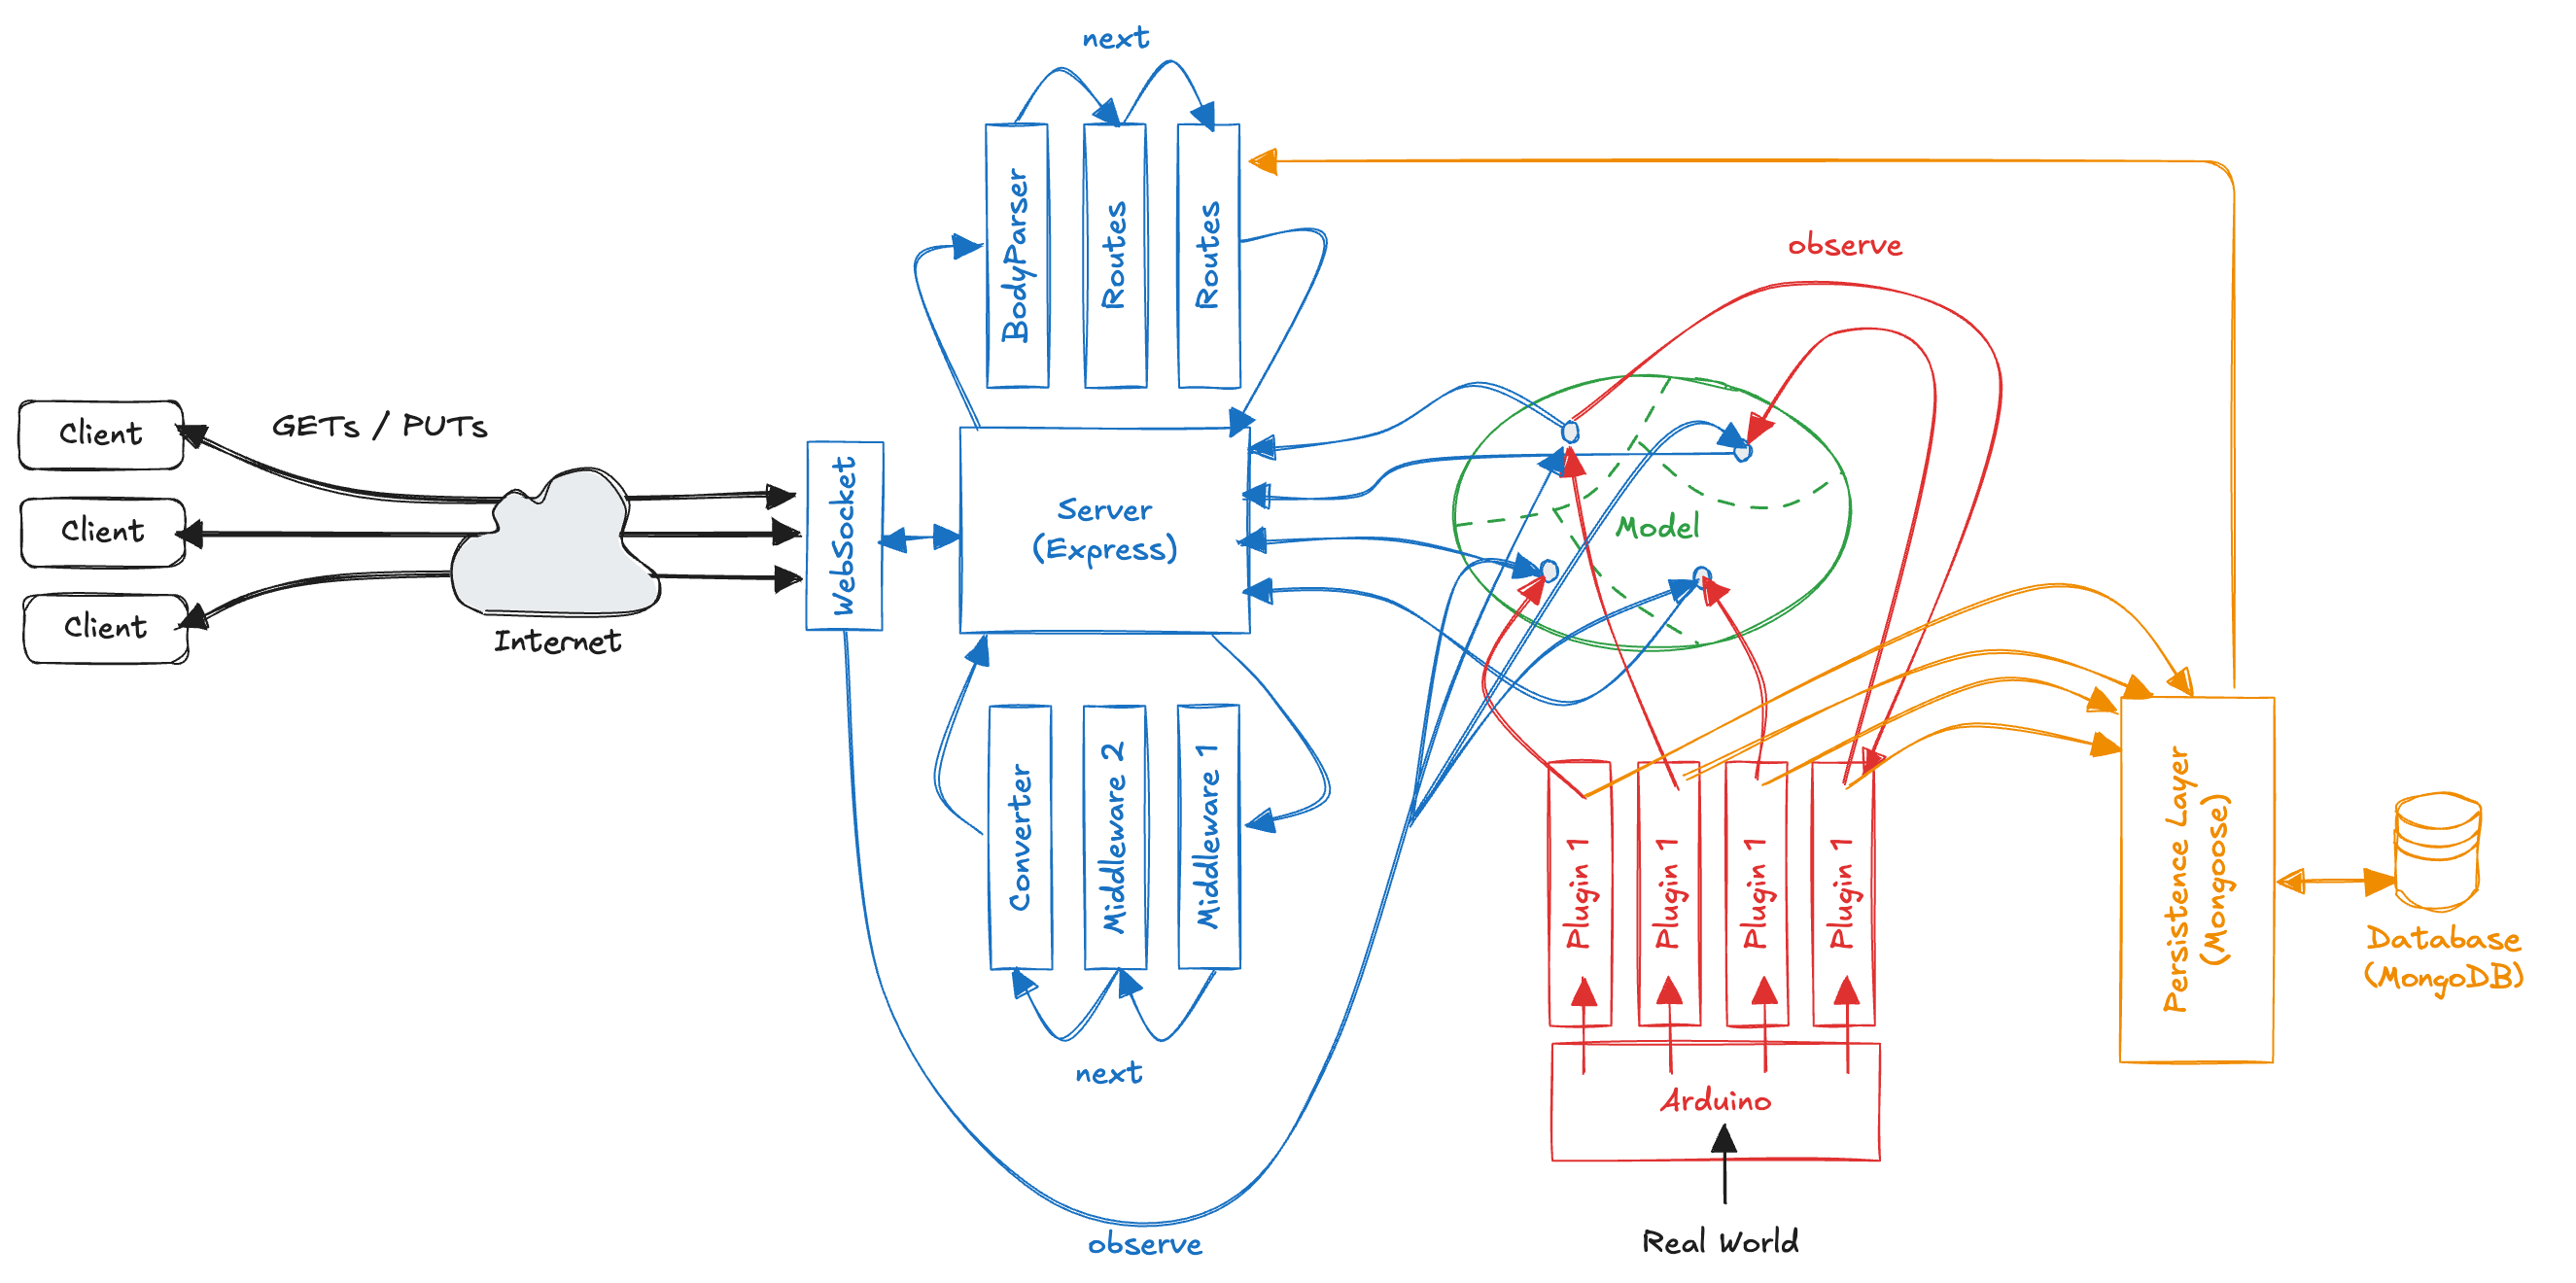

This setup abstracts direct database access away from the server logic and plugins, enabling centralized data management and making it easier to apply validation, track changes, and enforce consistency. Overall, the architecture demonstrates a clean use of ORM-based persistence, where the model is the focal point for both runtime operations and durable storage via Mongoose (see code/01. Persistent WoT Server code). 

We add a models folder to the src directory, which contains the Measurement schema and a list of measurement types (e.g. temperature and light):

In [ ]:
// /models/measurement.js

const mongoose = require('mongoose');

const measurementSchema = new mongoose.Schema({ 
    type: { type: String, required: true },
    value: { type: String },
    timestamp: { type: Date, default: Date.now }
});

measurementSchema.index({ type: 1 });
measurementSchema.plugin(require('mongoose-paginate'));

module.exports = mongoose.model('Measurement', measurementSchema);

In [ ]:
// /models/measurementTypes.js

const MeasurementTypes = Object.freeze({
    temperature: "temperature [Celsius degree]",
    light: "light [%]"
});

module.exports = MeasurementTypes;

Notice tha we use the popular "mongoose-paginate" plugin that simplify pagination support to Mongoose models. It handles the process of retrieving documents in paged batches, which is essential when dealing with large datasets in APIs or web applications.

We add a database.js file to contain the connection logic to MongoDB. This file is responsible for establishing a connection to the database and exporting the Measurement model for use in other parts of the application:

In [ ]:
// /database.js

const mongoose = require('mongoose');
const mongoosePaginate = require('mongoose-paginate');

mongoose.Promise = global.Promise; 
mongoose.connect(process.env.DATABASE);

mongoose.connection.on('error', (err) => {
  console.error('Database connection error '+ err.message);
});

mongoosePaginate.paginate.options = { 
  lean: false,
};

require('./models/measurementSchema');

The plugin should be modified to use the Measurement model to store values on the database:

In [ ]:
// /plugins/temperature.js

const resources = require('./../resources/model');
const observer = require("node-observer");
const mongoose = require('mongoose');
const MeasurementTypes = require('./../models/measurementTypes');
const Measurement = mongoose.model('Measurement');

let interval;
const model = resources.iot.sensors.temperature;
const pluginName = resources.iot.sensors.temperature.name;
const unit = resources.iot.sensors.temperature.unit;
let localParams = {'simulate': true, 'frequency': 2000};

// Starts the plugin, should be accessible from other
// files so we export them
exports.start = function (params) {
  localParams = params;
  if (localParams.simulate) { simulate(); } 
  else { connectHardware(); }
};

// Stop the plugin, should be accessible from other
// files so we export them
exports.stop = function () {
  clearInterval(interval);
  console.info('%s plugin stopped!', pluginName);
};

// Require and connect the actual hardware driver and configure it
function connectHardware() {
  var arduino = require('./../hardware/arduino');
  interval = setInterval(function () { 
    model.value = arduino.temperature; 
    (new Measurement({ type:MeasurementTypes.temperature, value: model.value })).save();    
    }, localParams.frequency);
  console.info('Hardware %s sensor started!', pluginName);
};

// Allows the plugin to be in simulation mode. This is very useful when developing
// or when you want to test your code on a device with no sensors connected, such as your laptop
function simulate() {
  interval = setInterval(function () { 
    model.value += 1; 
    observer.send(this, model.name , model.value);
    (new Measurement({ type:MeasurementTypes.temperature, value: model.value })).save();
    showValue(); 
  }, localParams.frequency);
  console.info('Simulated %s sensor started!', pluginName);
};

function showValue() { console.info('%s value = %s %s', pluginName, model.value, unit); };

Then we add a new route to handle incoming requests for accessing stored measurements. This route will use the Measurement model to query the database and return the results in a paginated format:

In [ ]:
// /routes/measurements.js

const express = require('express');
const router = express.Router();
const mongoose = require('mongoose');
const Measurement = mongoose.model('Measurement');

router.route('/').get(async function (req, res, next) {
    try {
        if (!req.query.page) req.query.page = '1';
        if (!req.query.limit) req.query.limit = '10';
        if (req.query.limit > 100) req.query.limit = '100';
        if (!req.query.filter) req.query.filter = '{}';
        if (!req.query.sort) req.query.sort = "{ \"timestamp\": \"desc\" }";
        if (!req.query.select) req.query.select = '{}';
        if (req.query.filter.startsWith("[")) { req.query.filter = "{ \"$or\": " + req.query.filter + " }" };
        const filter = JSON.parse(req.query.filter);
        const options = {
            select: JSON.parse(req.query.select),
            sort: JSON.parse(req.query.sort),
            page: parseInt(req.query.page),
            limit: parseInt(req.query.limit)
        }
        const measurements = await Measurement.paginate(filter, options);
        req.result = measurements;
        next();
    }
    catch (err) { return res.status(500).json({ status: 500, message: err.message }) };
});

module.exports = router;

Notice that we use the query parameter of the request to filter the measurements and define the pagination.

Finally, we require the database.js file in the entry point of the application to ensure that the database connection is established when the server starts:

In [ ]:

// Load the database, the http server, the websocekt server and the model
const db = require('./database');
const httpServer = require('./servers/http');
const resources = require('./resources/model');
const wsServer = require('./servers/websockets');

// Require all the sensor plugins we need
const ledsPlugin = require('./plugins/ledsPlugin');
const pirPlugin = require('./plugins/pirPlugin');
const tempPlugin = require('./plugins/tempPlugin');
const lightPlugin = require('./plugins/lightPlugin');

// Start them with a parameter object. Here we start them on a
// laptop so we activate the simulation function
ledsPlugin.start({'simulate': true, 'frequency': 1000});
pirPlugin.start({'simulate': true, 'frequency': 1000});
tempPlugin.start({'simulate': true, 'frequency': 1000});
lightPlugin.start({'simulate': true, 'frequency': 1000});
 
const server = httpServer.listen(resources.iot.port, function () {
   console.info('Your WoT Pi is up and running on port %s', resources.iot.port);
});
 
// Websockets server
wsServer.listen(server);

A simple request to the /measurements endpoint will return a paginated list of measurements stored in the database: 

In [ ]:
GET http:{{base_url}}/iot/measurements?filter={"type":"temperature [Celsius degree]"}&limit=2&page=6

The response will include the total number of documents, the current page, and the number of documents per page, along with the actual measurement data. This allows us to easily navigate through large datasets without overwhelming the client or server:

In [ ]:
{
    "docs": [
        {
            "_id": "682de6356a75fb61029c6c09",
            "type": "temperature [Celsius degree]",
            "value": "2",
            "timestamp": "2025-05-21T14:41:57.222Z",
            "__v": 0
        },
        {
            "_id": "682de6346a75fb61029c6c07",
            "type": "temperature [Celsius degree]",
            "value": "1",
            "timestamp": "2025-05-21T14:41:56.224Z",
            "__v": 0
        }
    ],
    "total": 12,
    "limit": 2,
    "page": 6,
    "pages": 6
}

## Hands-on Activity

Create a user collection and populate it with several user documents, each containing fields such as name, surname, phone, address, gender, and birthDate.
Practice using different query selectors with the find method to retrieve specific subsets of users—for example, all female users or users under 40 years old.
Experiment with additional MongoDB operations like count and remove to explore document statistics and deletion.

Extend the WoT Proxy by defining a new schema for log entries.Each time the API receives a request, a new log document should be created and stored in the database.
Add a new route that exposes the logs, making it possible to retrieve them via an HTTP request.